### Análise de sentimentos dos comentários em vídeos do YouTube

In [1]:
import os
# import numpy as np
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from googletrans import Translator
# from api_youtube import get_comment_replies

import nltk
from nltk.corpus import stopwords

# import nltk
import re
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn import metrics
# from sklearn.model_selection import cross_val_predict

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

pd.options.mode.chained_assignment = None

#### Vamos iniciar lendo a base coletada

In [2]:
df = pd.read_csv('result.csv', sep=';', encoding='UTF-8')
df.rename(columns={'Comentarios': 'texto-pt'}, inplace=True)
df

,index,texto-pt
0,0,Em pleno 2024 do nada ativou a Siri aqui no me...
1,1,"Ainda vale compensa comprar o 1 ,2ou até mesmo..."
2,2,Alguém em 2022?
3,3,Como mudou! Hoje estamos na versão 7
4,4,"apple e apple,sem comentário de consumo"
...,...,...
246,246,Análise top
247,247,Faiz os vídeos de vale a pena comprar ou não.
248,248,Nicolas cage Nenhum produto da Apple no Brasil...
249,249,O ipad vale a pena


#### Traduzir texto para uma amostra mais precisa

In [4]:
# traduzir para o ingles onde o vetorizador possa trabalhar melhor
tradutor = Translator()
def traduzir_texto(texto):
    return tradutor.translate(texto, dest='en').text  # Traduz para o inglês

df['texto-en'] = df['texto-pt'].apply(traduzir_texto)
df.head(4)

,index,texto-pt,texto-en
0,0,Em pleno 2024 do nada ativou a Siri aqui no me...,In the middle of 2024 out of nowhere activated...
1,1,"Ainda vale compensa comprar o 1 ,2ou até mesmo...",Is it still worth it to buy 12 or even 3 in 2023?
2,2,Alguém em 2022?,Someone in 2022?
3,3,Como mudou! Hoje estamos na versão 7,How it changed!Today we are in version 7


#### Limpando o dataset *(base de dados)*

In [5]:
# remover valores em branco
df.dropna(subset=['texto-en'])

df['texto-en'] = df['texto-en'].str.lower()

# Função para remover emojis do texto
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Símbolos e pictogramas
        "\U0001F680-\U0001F6FF"  # Símbolos de transporte e mapas
        "\U0001F1E0-\U0001F1FF"  # Bandeiras (iOS)
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)
df['texto-en'] = df['texto-en'].apply(remove_emojis)

# remover pontuação e caractere especial do texto
df['texto-en'] = df['texto-en'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)

df.head(3)

,index,texto-pt,texto-en
0,0,Em pleno 2024 do nada ativou a Siri aqui no me...,in the middle of 2024 out of nowhere activated...
1,1,"Ainda vale compensa comprar o 1 ,2ou até mesmo...",is it still worth it to buy 12 or even 3 in 2023
2,2,Alguém em 2022?,someone in 2022


##### Stopwords

In [6]:
# Função para remover stopwords(palavras indesejadas) com base no idioma
nltk.download('stopwords', quiet=True)

def remover_stopwords(texto, idioma='portuguese'):
    # Obtém as stopwords do idioma escolhido
    stopwords_idioma = set(stopwords.words(idioma))
    palavras = texto.split()
    resultado = [palavra for palavra in palavras if palavra.lower() not in stopwords_idioma]
    return ' '.join(resultado)


df['texto_pt_limpo'] = df['texto-pt'].apply(remover_stopwords, idioma='portuguese')
df['texto-en'] = df['texto-en'].apply(remover_stopwords, idioma='english')

print(df[['texto-pt', 'texto_pt_limpo']].head(3))

                                            texto-pt  \
0  Em pleno 2024 do nada ativou a Siri aqui no me...   
1  Ainda vale compensa comprar o 1 ,2ou até mesmo...   
2                                    Alguém em 2022?   

                                texto_pt_limpo  
0     pleno 2024 nada ativou Siri aqui celular  
1  Ainda vale compensa comprar 1 ,2ou 3 2023 ?  
2                                 Alguém 2022?  


### Iniciar o VADER para criar o alvo
Cria uma categorização com um modelo do NLTK VADER <br>
para definir a situação do texto *(positivo, negativo e neutro)*



In [7]:
# Iniciar o VADER 
vader = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['texto-en'].apply(vader.polarity_scores)

# Extrair o compound e categorize sentiment
df['compound'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment'] = df['compound'].apply(lambda c: 'positivo' if c >= 0.05 else ('negativo' if c <= -0.05 else 'neutro'))


#### Alvo pronto, vamos conferir a amostra

In [8]:
print(df[['texto-pt','sentiment']])

                                              texto-pt sentiment
0    Em pleno 2024 do nada ativou a Siri aqui no me...    neutro
1    Ainda vale compensa comprar o 1 ,2ou até mesmo...  positivo
2                                      Alguém em 2022?    neutro
3                 Como mudou! Hoje estamos na versão 7    neutro
4              apple e apple,sem comentário de consumo    neutro
..                                                 ...       ...
246                                       Análise top   positivo
247      Faiz os vídeos de vale a pena comprar ou não.  positivo
248  Nicolas cage Nenhum produto da Apple no Brasil...  positivo
249                                 O ipad vale a pena  positivo
250                         +Yeahhh b1tch r VC é bosta  negativo

[251 rows x 2 columns]


<br>
<br>
<br>
Contagem acumulativa por sentimento

In [9]:
df['sentiment'].value_counts()

sentiment
neutro      127
positivo     86
negativo     38
Name: count, dtype: int64

Separando base
<br>
<br>
Positivo x Negativo

In [10]:
df_positivo = df[df['sentiment'] == 'positivo']
df_negativo = df[df['sentiment'] == 'negativo']
df_positivo.head(4)

,index,texto-pt,texto-en,texto_pt_limpo,sentiment_scores,compound,sentiment
1,1,"Ainda vale compensa comprar o 1 ,2ou até mesmo...",still worth buy 12 even 3 2023,"Ainda vale compensa comprar 1 ,2ou 3 2023 ?","{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...",0.2263,positivo
6,6,"Ganhei o meu no natal de 2015, sou mega apaixo...",mine christmas 2015 im mega love himi use ever...,"Ganhei natal 2015, mega apaixonada ele. Uso to...","{'neg': 0.0, 'neu': 0.648, 'pos': 0.352, 'comp...",0.8834,positivo
11,11,"Dezembro de 2021, comprei meu series 7 haha",december 2021 bought series 7 haha,"Dezembro 2021, comprei series 7 haha","{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'comp...",0.4588,positivo
18,18,Quem não quê es a beleza,beauty,quê es beleza,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.5859,positivo


Nuvem de palavras mais utilizadas na nossa coleta

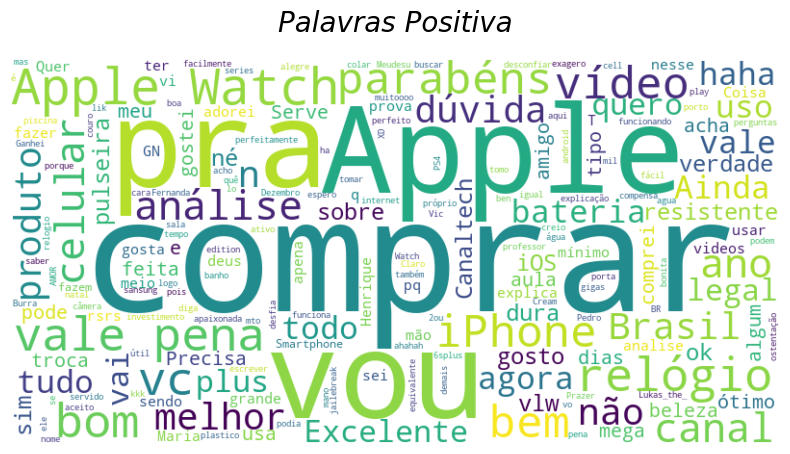

In [11]:
def nuvem_palavras(df_entrada, coluna_entrada, titulo):
    texto_completo = " ".join(df_entrada[coluna_entrada])
    # Gerar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)
    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Desativa os eixos
    plt.title(titulo, fontsize=20, pad=20, style='italic')
    plt.show()


nuvem_palavras(df_positivo, 'texto_pt_limpo', titulo='Palavras Positiva')

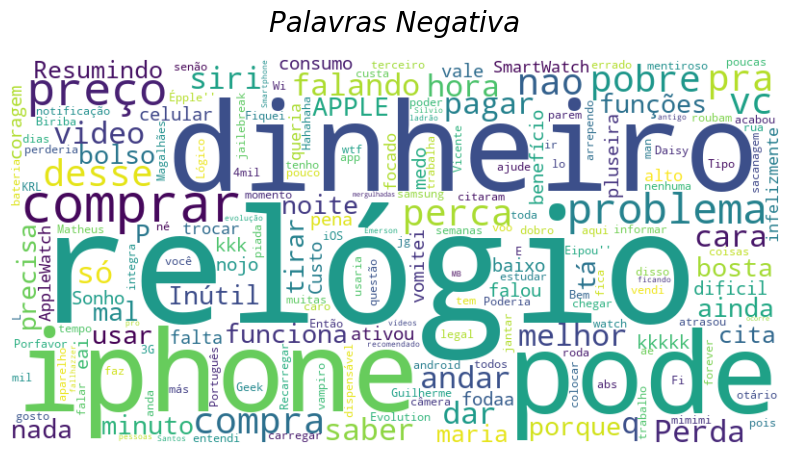

In [12]:
nuvem_palavras(df_negativo, 'texto_pt_limpo', titulo='Palavras Negativa')

#### Pronto! Conseguimos chegar em alguns objetivos 🎉🤩 <br>

Classificação do texto (positivo, negativo e neutro)<br>
Resultado de palavras mais utilizadas
<br>
<br>
Definitivamente há espaço para melhorias. Mas, tenha em mente que obtivemos essa pontuação sem fazer nenhuma alteração no VADER